# Example X: System identification

This example considers identification of modal properties using measured response data. 

As engineers working with dynamic problems, it is very important to have a good overview of modal properties of the structure. The modal properties are traditionally obtained from solving the eigenvalue problem $ [-\omega^2 \mathbf{M}+\mathbf{K} ] \mathbf{v} = \mathbf{0}$. This requires that the mass and stiffness matrices are available, for instance from a finite element model. 

If we are working with existing structures, it is also possible to estimate the modal properties from measurements of structural responses. To measure the response, a variety of alternatives is available:

- Accelerometers: this is the most common altenative. These sensors are cheap ande easy to install.
- Strain gauges: are cheap, but installation requires access to the metallic surface of the structural component.
- GPS/GNSS: this alternative is only feasible for structures with large motions, since the accuracy is in the order of cm/mm.
- Laser: measures displacements. Requires a fixed point for the sensor, and a short distance to the target.
- Video: it is possible to film the structure and track its motion frame-by-frame. This is very computationally expensive.

Why do measurements when we have computer models and fancy software? There are many reasons one wishes to perform modal identification or system identification:

- The system (structure) is complicated and not easy to model accurately.
- Model and parameter uncertainties are present, meaning the engineer do not fully know how to model the structure with high precision. For instance, values for some structural parameters are unknown, exact boundary contitions are unknown, joint behavior is unknown (fixed, hinged, or something inbetween?), non-structural masses are unknown. 
- The modal information can be used to calibrate system parameters. For instance, the tension in a cable can be estimated if the natural frequencies of the cable are measured.
- Whereas mass and stiffness of materials are usually linked to well-known physics (beam theory), damping is a complex phenomenon that is not easy to predict.
- To track the modal properties over a long time period (weeks, months, years,...). Any changes over time could indicate evolving damage, or other unwanted changes in the structure.
- Verification of a computer model of the structure, or verifying that the structure behaves as intented in design.

The easiest method to determine natural frequencies and damping ratios is to consider time histories of free vibration (i.e., give the structure a small force impulse and let the response decay to zero). However, this is rarely possible outside laboratory experiments since: *i)* it is not easy to isolate the motion to only one specific mode at a time; *ii)* structures in-situ (buildings, towers, bridges, ...) are not in free vibration but continuously excited by so-called ambient excitation (traffic, wind, human loading, ... ).

The two methods presented in the following are based on response spectra, so we will generally assume that the response is a stationary stochastic process.

## Method 1:  basic frequency domain method and peak picking

We already know that the response spectrum for a MDOF system is given by theory as $ \mathbf{S}_x(\omega)= \mathbf{H}(\omega) \mathbf{S}_p(\omega) \mathbf{H}(\omega)^H $.

We start with the response time series $x(t)$ and produce its spectrum using the FFT or Welch's method. Next, peak picking is simply the act of locating the peaks in the response spectrum. These peaks originate from the dynamic amplification around the natural frequency. One should be careful since some peaks could indicate not a natural frequency but a distinct harmonic component in the loading, e.g. a rotating machinery. It is also neccessary that the modes are excited sufficiently so that their contribution is visible in the spectrum. The number of modes contributing to the response could range from 1 to 100, and highly depends on the structure and its type of loading.

We often deal with acceleration time histories rather than displacements, but nothing in the procedure changes. We know that the acceleration spectrum is given by $ \mathbf{S}_{\ddot{x}}(\omega) = \omega^4 \mathbf{S}_x(\omega)$. The peaks in the spectrum will still be at the same locations, namely at the natural frequencies.

It is theoretically possible to also estimate damping by considering the shape of the peaks: low modal damping ratios lead to tall and narrow peaks, and high modal damping ratios lead to blunt peaks. This is however much more difficult in practice than estimating the natural frequencies, and is not covered here.

Let us simulate some response data using the structure from example 4.1.

<img src=".\figures\Fig_4_1.svg">



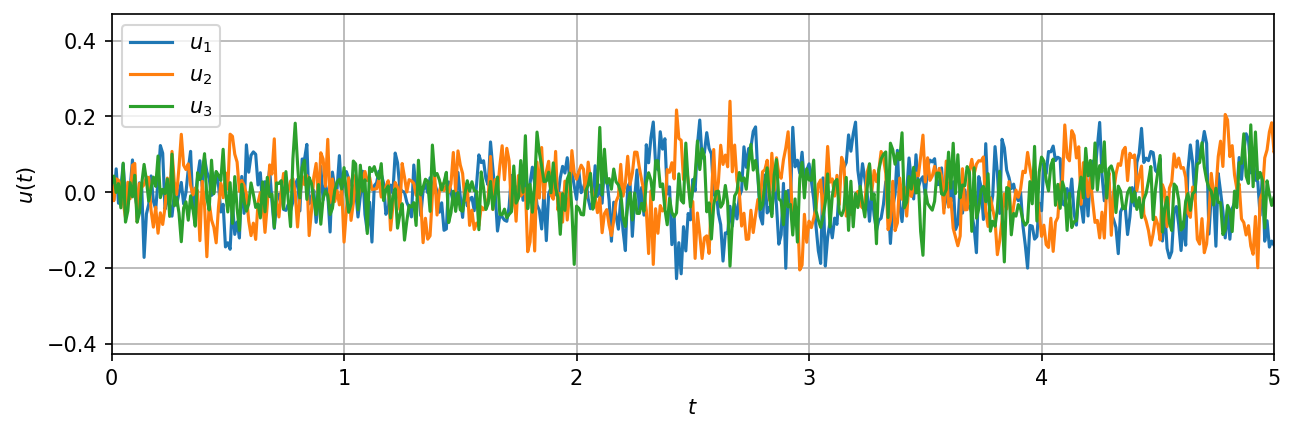

In [22]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as sps
from functions import sDynFunctions

# Structural properties
m = 1000.0; 
c = 2000.0;
EI = 2.1E11*3.36E-6;
L = 4.0;
k = 2*12*EI/L**3;
MM = np.diag([1, 1, 1])*m;
KK = np.array([ [2, -1, 0], [-1, 2, -1], [0, -1, 1]])*k
CC = np.diag([1, 0.5, 0])*c;


dt=0.01 # Time step
T=600 # Total time
t = np.arange(0,T,dt) # Time vector

f=np.random.normal(0,50, size=(3,len(t))) # White noise loading

u0=np.zeros((3,1)) # Initial displacement
udot0=np.zeros((3,1)) # Initial velocity

u, udot, u2dot=sDynFunctions.linear_newmark_krenk(MM,CC,KK,f,u0,udot0,dt,0.5,0.25)
    
# Plot displacements
plt.figure(figsize=(10,3))   
plt.plot(t,u2dot[0,:],'-',label = '$u_1$')  
plt.plot(t,u2dot[1,:],'-',label = '$u_2$')    
plt.plot(t,u2dot[2,:],'-',label = '$u_3$')    
plt.xlabel('$t$')
plt.ylabel('$u(t)$');
plt.xlim(0,5)
plt.grid()
plt.legend()


Everything seems to look okay with the acceleration time series. Next, we estimate the spectrum using Welch's method.

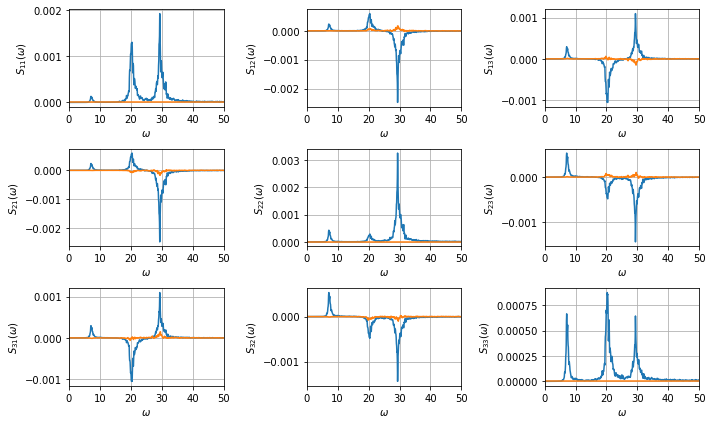

In [2]:
from scipy.signal import welch, hanning, csd

Ndivisions=10 # Number of divisions of the time series
Nwindow=np.ceil(len(t)/Ndivisions) # Length of window

Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2


# Spectral matrix
S_welch=np.zeros((3,3,np.int32(Nfft_pow2/2+1)),dtype=np.complex_)

# Fill spectral matrix by taking the cross spectral density between each of the 3 time series
for k1 in range(3):
    for k2 in range(3):
            f, S_Hz=csd(u2dot[k1,:],u2dot[k2,:], fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')
            
            w_welch=f*2*np.pi # Frequency axis in rad/s
            S_welch[k1,k2,:]=S_Hz/(2*np.pi) # Spectrum in rad/s
            
# Plot spectrum
fig, axs = plt.subplots(3,3,figsize=(10,6))    
for k1 in range(3):
    for k2 in range(3):
        ax = axs[k1,k2]
        ax.plot(w_welch,np.real(S_welch[k1,k2,:]))
        ax.plot(w_welch,np.imag(S_welch[k1,k2,:]))
        ax.set_ylabel(('$S_{' + str(k1+1) + str(k2+1) + '}(\omega)$'))
        ax.set_xlabel('$\omega$')
        ax.grid(True)
        #ax.set_yscale('log')
        ax.set_xlim(0,50)
plt.tight_layout()



It is easy to pick out the natural frequencies by visual inspection: approximately 8, 20, and 29 rad/s.

The Welch-functions in Python usually produces spectral density $S(f)$ and frequency axis $f$ in Hz. If you want to convert to rad/s, remember to scale by $2 \pi$.


## Method 2: frequency domain decomposition (FDD)

This method is based on the singular value decomposition (SVD) of the cross-spectral density matrix. 

The SVD is widely used in linear algebra, and factorizes the matrix $\mathbf{M}$ on the form $\mathbf{M}=\mathbf{U} \mathbf{\Sigma} \mathbf{V}^H$, where $()^H$ denotes the Hermittian transpose (transpose + complex conjugate).  $\mathbf{\Sigma}=\text{diag}(\sigma_1,\sigma_2,\sigma_3,\dots)$ is a diagonal matrix with values called the singular values $\sigma_i$ (usually in descending order). The columns of $\mathbf{U}=[\mathbf{u}_1,\mathbf{u}_2,\mathbf{u}_3,\dots]$ are called singular vectors $\mathbf{u}_i$. The singular values $\sigma_i$ are always real, but the singular vectors $\mathbf{u}_i$ could be complex if $\mathbf{M}$ is complex.

The SVD can also be expressed as $\mathbf{M}=\sum_{k=1}^{N} \mathbf{u}_i \sigma_i \mathbf{v}_i^H$. In simple terms, each singular value describes the importance of the corresponding singular vector (bigger value=more import contribution to "building" the matrix $\mathbf{M}$).

Now let us consider how the SVD can be used in dynamics. The physical response can be expressed as the sum of contributions from all the modes $ \mathbf{x}(t)= \mathbf{\Phi} \mathbf{\eta}(t)$. This means that the spectrum of the response can be expressed as $ \mathbf{S}_x(\omega)= \mathbf{\Phi}\mathbf{S}_{\eta}(\omega) \mathbf{\Phi}^H $. When we compare this to the SVD, some similarity can be recognized .

Consider one specific frequency $\omega=\omega_s$. If this is a natural frequency of the structure, only one mode will dominate the total response at that frequency due to resonance (dynamic magnification). This implies that the spectral matrix can be approximated by only considering the first singular vector: $ \mathbf{S}_x(\omega_s) \approx \mathbf{u}_1 \sigma_1 \mathbf{v}_1^H$. The estimate of the mode shape is then $\mathbf{\phi}_s=\mathbf{u}_1$. Ideally, $\mathbf{\phi}_s$ should be real (or close to real). Due to noise and estimation uncertainty, however, $\mathbf{\phi}_s$ will also have an imaginary part. We usually neglect this part and consider the real part only.



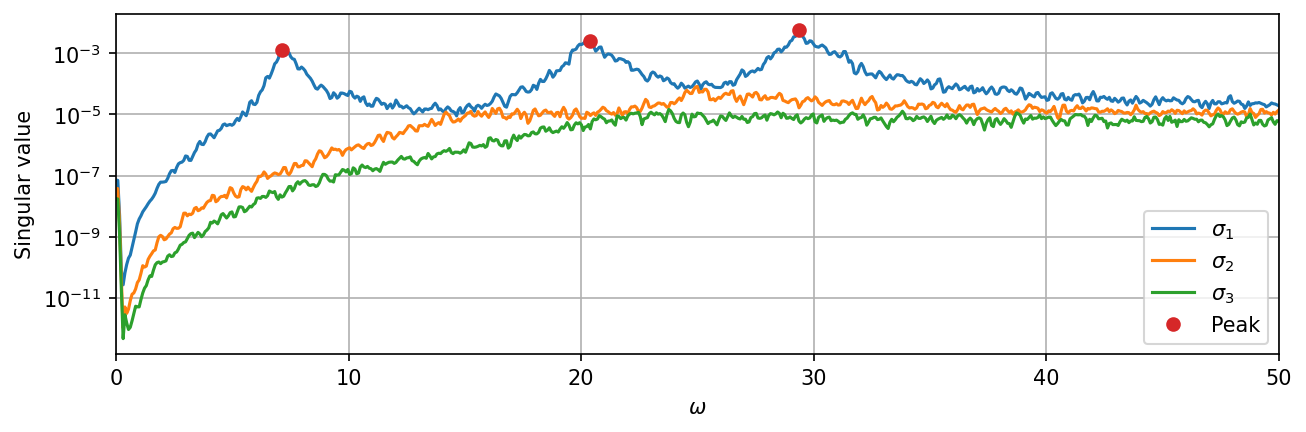

In [27]:
# Frequency domain decomposition
import scipy

# Zero matrices for singular value and singular vector
sigma1=np.zeros(len(w_welch))
sigma2=np.zeros(len(w_welch))
sigma3=np.zeros(len(w_welch))
u1=np.zeros((3,len(w_welch)),dtype=np.complex_)

# Loop over all frequencies 
for k in np.arange(len(w_welch)):

    u,sigma,v=np.linalg.svd(S_welch[:,:,k]) # SVD of slice of spectral matrix
    
    sigma1[k]=sigma[0] # Save first singular value
    u1[:,k]=u[:,0] # Save first singular vector
    sigma2[k]=sigma[1] # Save second singular value
    sigma3[k]=sigma[2] # Save third singular value
    
# Find index of peaks in singular spectrum
peaks_index,_ = scipy.signal.find_peaks(sigma1, distance=50, rel_height=0.5) 

# Pick 3 largest peaks
peaks_index_top3 = np.sort(peaks_index[np.argpartition(sigma1[peaks_index], -3)[-3:]])

# Plot singular value spectrum
plt.figure(figsize=(10,3))   
plt.plot(w_welch,sigma1,'-',label = '$\sigma_1$')
plt.plot(w_welch,sigma2,'-',label = '$\sigma_2$')
plt.plot(w_welch,sigma3,'-',label = '$\sigma_3$')
plt.plot(w_welch[peaks_index_top3],sigma1[peaks_index_top3],'o',label = 'Peak')    
plt.xlabel('$\omega$');
plt.ylabel('Singular value')
plt.yscale('log')
plt.xlim(0,50)
plt.grid()
plt.legend()   


We see that the peaks from the 3 modes are very visible and easy to pick out. They obviously match the same frequencies as the plot of the spectrum. At the natural frequencies, we see that the first singular value is much greater (10000x or 100x) than the next singular value. This shows that one mode is dominating the response at that frequency.

Next, let us plot the modes. The mode shapes are the singular vectors corresponding to the peaks above.

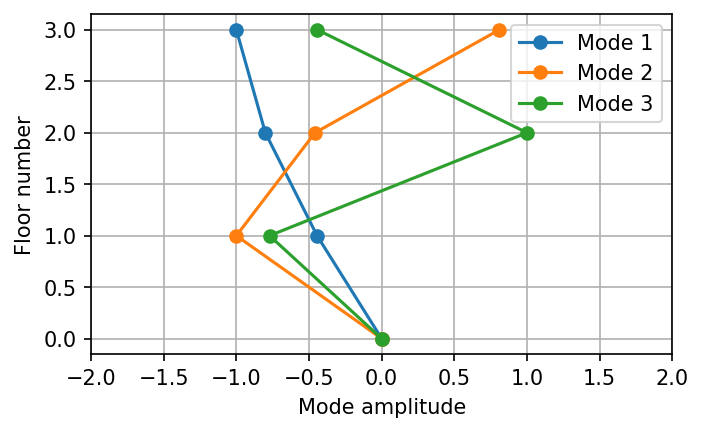

In [29]:
# Plot mode shapes

plt.figure(figsize=(5,3))   
for k in range(3):
    
    phi=u1[:,peaks_index_top3[k]] # Pick singular vector corresponding to peak
    phi=np.real(phi) # Take real part only
    phi=phi/np.max(np.abs(phi)) # Normalize max to 1 (mode scaling)
    phi=np.hstack((0,phi)) # Add zero value at base floor of building
    
    plt.plot(phi,np.arange(4),'-o',label = 'Mode '+str(k+1))    # Plot this mode 

plt.xlabel('Mode amplitude')
plt.ylabel('Floor number');
plt.xlim(-2,2)
plt.grid()
plt.legend()

We observe that the identified modes look reasonable: in mode 1, the entire building is swaying to one side. In mode 2, the first and third floor swing to opposite sides. We can try to animate mode 3.

<Figure size 450x450 with 0 Axes>

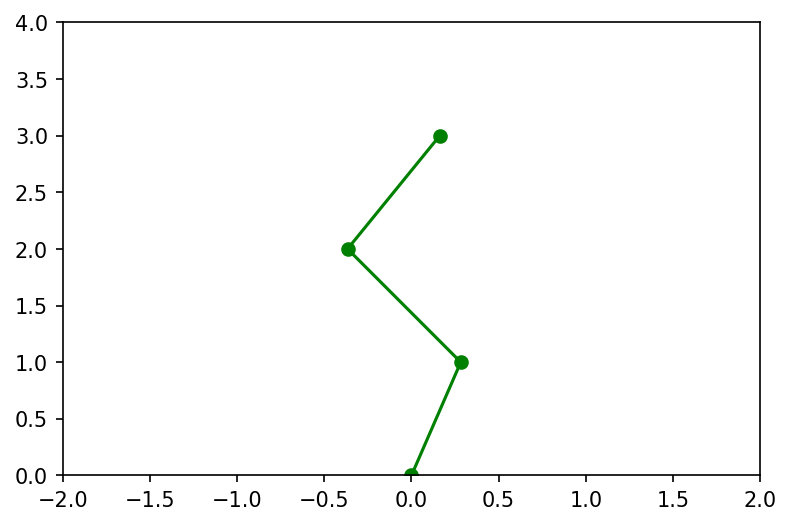

In [30]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

plt.figure(figsize=(3,3))
fig, ax = plt.subplots()

def animate(t):
    plt.cla()
    plt.plot(phi*np.sin(t/5),np.arange(4),'-og')
    plt.xlim(-2,2)
    plt.ylim(0,4)
matplotlib.animation.FuncAnimation(fig, animate, frames=50)
